In [2]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.tree_util import tree_flatten, tree_unflatten, tree_structure
import jax_dataclasses as jdc
import chex
from functools import partial
from typing import Callable
import os
from exciting_environments import PMSM_Physical,PMSM
#from exciting_environments.pmsm import FastPMSM
import matplotlib.pyplot as plt

In [3]:
# from jax import config
# config.update("jax_enable_x64", True)

In [4]:
random_seed_DQN = np.random.randint(0, 2**31)
random_key_DQN = jax.random.PRNGKey(seed=random_seed_DQN)
random_seed_motor = np.random.randint(0, 2**31)
random_key_motor = jax.random.PRNGKey(seed=random_seed_motor)

random_seed = np.random.randint(0, 2**31)
random_key = jax.random.PRNGKey(seed=random_seed)
random_key=random_key.astype(float)

In [5]:
new_motor = PMSM_Physical(control_state="torque", deadtime=0,batch_size=2,saturated=True)
new_motor_env = PMSM(new_motor, gamma=0.85,batch_size=2)

In [6]:
EPISODE_LENGTH = 500
NUM_EPISODES = 2_000
NUM_STATES = 2
x_star = np.zeros((NUM_STATES, NUM_EPISODES, NUM_STATES))
old_motor_env = FastPMSM(x_star,batch_size=2,saturated=True)
#obs, motor_env_state = new_motor_env.reset(random_key_motor)

NameError: name 'FastPMSM' is not defined

In [6]:
old_motor_env.reset()

(array([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]),
 {},
 False,
 {})

In [8]:
obs, motor_env_state = new_motor_env.reset()

In [9]:
motor_env_state

PMSM.State(physical_state=PMSM_Physical.PhysicalState(action_buffer=Array([], shape=(2, 0, 2), dtype=float32), epsilon=Array([0., 0.], dtype=float32), i_d=Array([0., 0.], dtype=float32), i_q=Array([0., 0.], dtype=float32), torque=Array([0., 0.], dtype=float32), omega=Array([0., 0.], dtype=float32)), PRNGKey=Array([[3.0423857e+09, 4.1139359e+09],
       [1.6089687e+09, 2.5743485e+09]], dtype=float32), additions=PMSM.Additions(omega_add=Array([[ 6.5484032e-06],
       [-4.0416639e-05]], dtype=float32), omega_count=Array([[20511.],
       [21179.]], dtype=float32), references=Array([[0.09325314],
       [0.9204607 ]], dtype=float32)))

### Comparison

In [9]:
obs

Array([[0.        , 0.        , 0.        , 1.        , 0.        ,
        0.997493  ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.88261056]], dtype=float32)

In [10]:
obs2,_,_,_=old_motor_env.step(np.array([[0.1,0.1],[1,1]]))

In [11]:
obs2

array([[2.05938254e-02, 3.10240515e-04, 3.14159282e-02, 0.00000000e+00,
        0.00000000e+00, 9.94750302e-02, 1.00522223e-01],
       [1.72050248e-01, 3.99474510e-02, 3.14159282e-02, 0.00000000e+00,
        0.00000000e+00, 8.13413567e-01, 9.00527415e-01]])

In [10]:
next_state,obs_next=new_motor_env.vmap_step(motor_env_state,jnp.array([[0.1,0.1],[1,1]]))

In [17]:
obs_next

Array([[ 1.6838914e-02,  4.0682431e-04,  3.1611507e-05,  9.9950653e-01,
         3.1410761e-02,  9.9749303e-01],
       [ 1.3863970e-01,  3.4562696e-02, -1.4881354e-05,  9.9950653e-01,
         3.1410761e-02,  8.8261056e-01]], dtype=float32)

### Step comparison

In [11]:
#old_motor_env.reset()
obs, motor_env_state = new_motor_env.reset(random_key_motor)
next_state=motor_env_state
i_dqs1=[]
i_dqs2=[]
for _ in range(100):
    act1=[0.03,0.03]
    act2=[0.03,0.03]
    obs_next,next_state=new_motor_env.vmap_step(next_state,jnp.array([act1,act2]))
    #obs2,_,_,_=old_motor_env.step(np.array([act1,act2]))
    i_dqs1.append(obs_next[0,0:2])
    #i_dqs2.append(obs2[0,0:2])
    # if done.any():
    #     break

ValueError: Incompatible shapes for broadcasting: shapes=[(100, 2), (0,)]

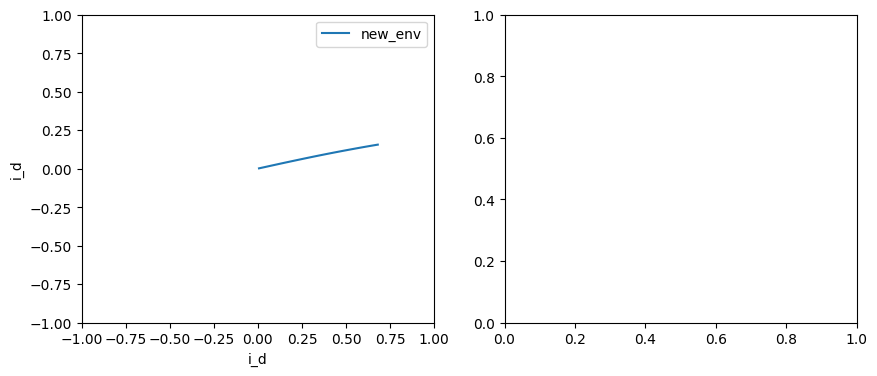

In [13]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].plot(jnp.array(i_dqs1)[:,0],jnp.array(i_dqs1)[:,1],label="new_env")
#ax[0].plot(jnp.array(i_dqs2)[:,0],jnp.array(i_dqs2)[:,1],label="old_env")
ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)
ax[0].set_xlabel("i_d")
ax[0].set_ylabel("i_d")
ax[0].legend()

ax[1].plot(jnp.linalg.norm(jnp.array(i_dqs1)-jnp.array(i_dqs2),axis=1),label="absolute error")
ax[1].legend()

## Constraints test

In [ ]:
ROTATION_MAP = np.ones((2, 2, 2), dtype=np.complex64)
ROTATION_MAP[1, 0, 1] = 0.5 * (1 + np.sqrt(3) * 1j)
ROTATION_MAP[1, 1, 0] = 0.5 * (1 - np.sqrt(3) * 1j)
ROTATION_MAP[0, 1, 0] = 0.5 * (-1 - np.sqrt(3) * 1j)
ROTATION_MAP[0, 1, 1] = -1
ROTATION_MAP[0, 0, 1] = 0.5 * (-1 + np.sqrt(3) * 1j)
def apply_hex_constraint(u_albet):
    """Clip voltages in alpha/beta coordinates into the voltage hexagon"""
    u_albet_c = u_albet[:, 0] + 1j * u_albet[:, 1]
    idx = (np.sin(np.angle(u_albet_c)[..., np.newaxis] - 2 / 3 * np.pi * np.arange(3)) >= 0).astype(int)
    rot_vecs = ROTATION_MAP[idx[:, 0], idx[:, 1], idx[:, 2]]
    # rotate sectors upwards
    np.multiply(u_albet_c, rot_vecs, out=u_albet_c)
    np.clip(u_albet_c.real, -2 / 3, 2 / 3, out=u_albet_c.real)
    np.clip(u_albet_c.imag, 0, 2 / 3 * np.sqrt(3), out=u_albet_c.imag)
    np.multiply(u_albet_c, np.conjugate(rot_vecs), out=u_albet_c)  # rotate back
    return jnp.column_stack([u_albet_c.real, u_albet_c.imag])

In [ ]:
apply_hex_constraint(np.array([[1,1]]))

Array([[0.8169873 , 0.89433753]], dtype=float32)

In [ ]:
old_motor_env.apply_hex_constraint

## jax.grad() for pmsm

In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.tree_util import tree_flatten, tree_unflatten, tree_structure
import jax_dataclasses as jdc
import chex
from functools import partial
from typing import Callable
import os
from exciting_environments import PMSM_Physical,PMSM
from exciting_environments.pmsm import FastPMSM
import matplotlib.pyplot as plt

In [ ]:
from matplotlib.patches import RegularPolygon
def plot_hexagon_ad(actions_alpha_beta, u_unnormalized, dot_size=5):

    actions_alpha = actions_alpha_beta[:, 0]
    actions_beta = actions_alpha_beta[:, 1]

    actions_un_alpha = u_unnormalized[:, 0]
    actions_un_beta = u_unnormalized[:, 1]

    fig, ax = plt.subplots(1, figsize=(3, 3))
    ax.grid()
    ax.set_axisbelow(True)
    ax.scatter(actions_alpha, actions_beta, s=dot_size, color="b", alpha=1)
    ax.scatter(actions_un_alpha, actions_un_beta, s=dot_size, color="r", alpha=1)
    
    ax.set_xlabel("Action alpha")
    ax.set_ylabel("Action beta")
    
    # hex = RegularPolygon((0, 0), numVertices=6, radius=2./np.sqrt(3), alpha=0.5, edgecolor='k')
    # ax.add_patch(hex)
    hex2 = RegularPolygon((0, 0), numVertices=6, radius=4./3., orientation=np.deg2rad(
        30), alpha=0.5, edgecolor='black', facecolor='none', linewidth=2)
    ax.add_patch(hex2)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    

In [ ]:
random_seed_DQN = np.random.randint(0, 2**31)
random_key_DQN = jax.random.PRNGKey(seed=random_seed_DQN)
random_seed_motor = np.random.randint(0, 2**31)
random_key_motor = jax.random.PRNGKey(seed=random_seed_motor)

random_seed = np.random.randint(0, 2**31)
random_key = jax.random.PRNGKey(seed=random_seed)
random_key=random_key.astype(float)

In [ ]:
new_motor = PMSM_Physical(control_state="torque", deadtime=0,batch_size=1,saturated=False)
new_motor_env = PMSM(new_motor, gamma=0.85,batch_size=1)
obs, motor_env_state = new_motor_env.reset(random_key_motor)

In [ ]:
motor_env_state.physical_state

PMSM_Physical.PhysicalState(action_buffer=Array([], shape=(1, 0, 2), dtype=float32), epsilon=Array([0.], dtype=float32), i_d=Array([0.], dtype=float32), i_q=Array([0.], dtype=float32), torque=Array([0.], dtype=float32), omega=Array([0.], dtype=float32))

In [ ]:
def output_to_scalar(state,act):
    next_state,obs_next,reward,done=new_motor_env.vmap_step(state,act)
    return jnp.squeeze(next_state.physical_state.i_d)
grad_step=jax.grad(output_to_scalar,1)

In [ ]:
acts=jnp.linspace(0,2.1,200)[:,None,None].repeat(2,axis=1)
acts_resh=jnp.moveaxis(acts,1,2)
gradient_diff_actions=jax.vmap(grad_step,in_axes=(None,0))(motor_env_state,acts_resh)[:,:,0]#jnp.array([[0.1,0.1]])

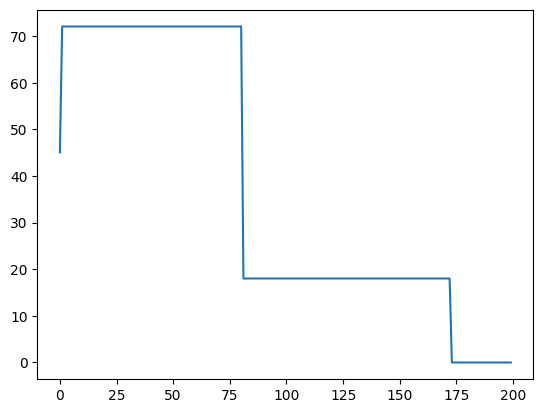

In [ ]:
plt.plot(gradient_diff_actions)

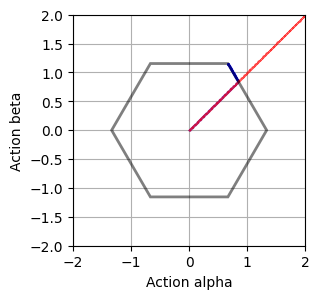

In [ ]:
acts_reshaped=acts.reshape(-1,2)
acts_constraint_all=jax.vmap(new_motor_env.constraint_denormalization, in_axes=(0,None,None))(acts_reshaped,motor_env_state,new_motor_env.env_properties)/266.666
plot_hexagon_ad(acts_constraint_all, acts_reshaped,dot_size=0.1)

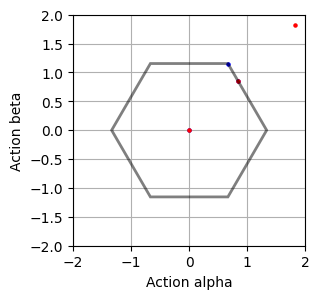

In [ ]:
ef=(jnp.argwhere(jnp.diff(gradient_diff_actions.reshape(-1)) != 0)).reshape(-1)
acts_special=acts[ef].reshape(-1,2)
acts_constraint=jax.vmap(new_motor_env.constraint_denormalization, in_axes=(0,None,None))(acts_special,motor_env_state,new_motor_env.env_properties)/266.666
plot_hexagon_ad(acts_constraint,acts_special)

In [ ]:
l_d=new_motor_env.env_properties.static_params.physical_properties.physical_params.l_d
l_q=new_motor_env.env_properties.static_params.physical_properties.physical_params.l_q
u_max=new_motor_env.env_properties.action_constraints.u_dq
tau=new_motor_env.tau

### gradient for u_dq without constraints

In [ ]:
1/l_d * tau * u_max

72.07207207207207